In [1]:
from anthropic import Anthropic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import re
import timeit

In [2]:
# Example of counting tokens:
client = Anthropic()
client.count_tokens('Hello world!')  # 3

3

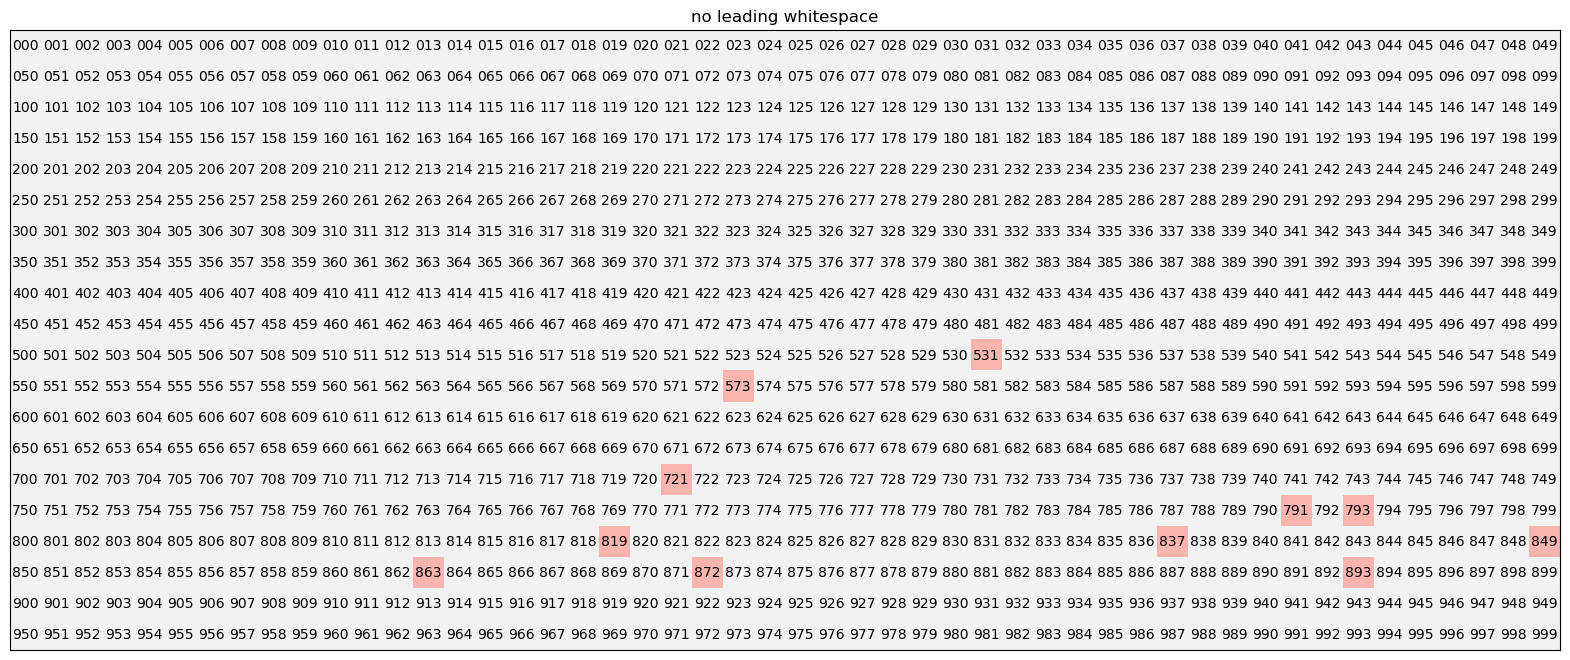

In [3]:
#@title Print a grid of all numbers, colored by whether or not they have a token.
save_fig = False
num_digits = 3
ws = False
num_rows = 20
fig_size = (20, 20)

if 10**num_digits % num_rows > 0:
  raise ValueError(f'10^num_digits ({10**num_digits}) must be divisible by num_rows ({num_rows}).')
num_cols = int(10**num_digits / num_rows)

# gather data
is_token = [] # boolean
labels = [] # string rep of numbers
for i in range(10**num_digits):
  str_rep = str(i).zfill(num_digits)
  labels.append(str_rep)
  if ws:
    str_rep = ' ' + str_rep
  is_token.append(client.count_tokens(str_rep) == 1)
is_token = np.reshape(is_token, (num_rows, num_cols))
labels = np.reshape(labels, (num_rows, num_cols))

# plot
fig = plt.figure(figsize=fig_size)
ax = plt.gca()
ax.matshow(is_token, cmap='Pastel1')
for (i, j), z in np.ndenumerate(labels):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')
plt.xticks([])
plt.yticks([])
if not save_fig:
  if ws:
    plt.title('with leading whitespace')
  else:
    plt.title('no leading whitespace')
if save_fig:
  if ws:
    ws_str = 'with_ws'
  else:
    ws_str = 'no_ws'
  plt.savefig(f'figures/anthropic_{num_digits}digit_tokens_{ws_str}_{num_rows}rows.pdf', bbox_inches='tight')
plt.show()

In [4]:
# Turn above data into dataframe for easier plotting.
max_digits = 6
df = pd.DataFrame(columns=['num_digits', 'leading_whitespace', 'num_tokens', 'num_possible_tokens'])

dfs = []
for num_digits in range(1, max_digits+1):
  for ws in [False, True]:
    is_token = [] # boolean
    for i in range(10**num_digits):
      str_rep = str(i).zfill(num_digits)
      if ws:
        str_rep = ' ' + str_rep
      is_token.append(client.count_tokens(str_rep) == 1)
    df = pd.DataFrame({
      'num_digits': num_digits,
      'leading_whitespace': ws,
      'num_tokens': np.sum(is_token),
      'num_possible_tokens': len(is_token),
      'token_coverage': np.mean(is_token),
      },
      index=[0])
    dfs.append(df)

df = pd.concat(dfs).reset_index()
del df['index']

In [5]:
df

,num_digits,leading_whitespace,num_tokens,num_possible_tokens,token_coverage
0,1,False,10,10,1.000000
1,1,True,10,10,1.000000
2,2,False,100,100,1.000000
3,2,True,100,100,1.000000
4,3,False,989,1000,0.989000
5,3,True,403,1000,0.403000
6,4,False,382,10000,0.038200
7,4,True,205,10000,0.020500
8,5,False,67,100000,0.000670
9,5,True,11,100000,0.000110


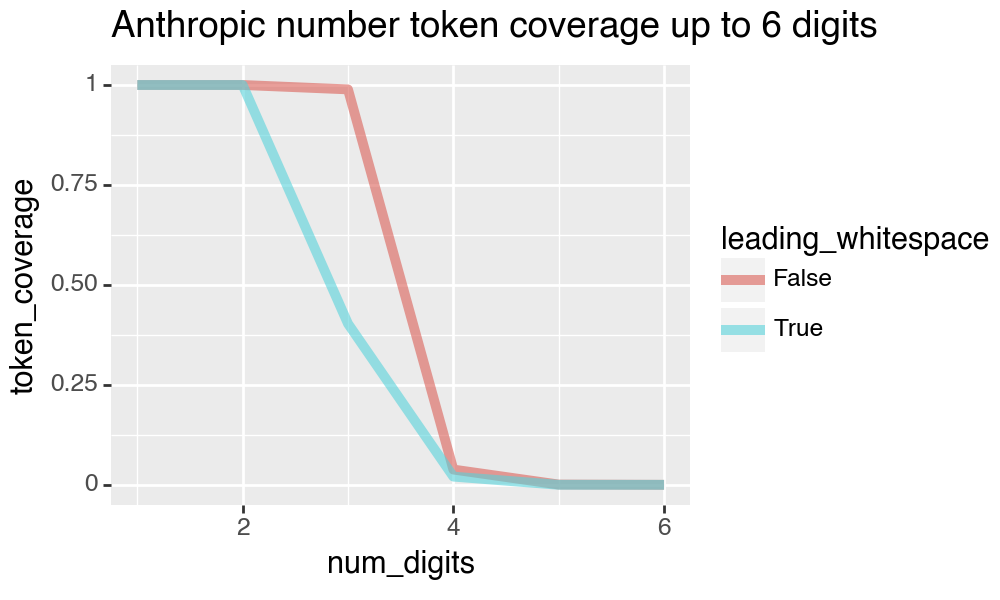

In [6]:
#@title Plot token coverage over tokenizers, digits, and with/without whitespace
max_digits = 6 # @param {'type': 'integer'}
plot = (gg.ggplot(df)
             + gg.aes(x='num_digits', y='token_coverage', colour='leading_whitespace',
                      group='leading_whitespace')
             + gg.geom_line(size=2, alpha=0.6)  # additional options
             + gg.xlim(1, max_digits)
             + gg.theme(figure_size=(5, 3))
             + gg.ggtitle(f'Anthropic number token coverage up to {max_digits} digits')
             )

print(plot)

In [7]:
# print all k digit
num_digits = 6
ws = False

for i in range(10**num_digits):
  str_rep = str(i).zfill(num_digits)
  if ws:
    str_rep = ' ' + str_rep
  if client.count_tokens(str_rep) == 1:
    print(str_rep)

000000
000001
002590
003048
026166
072017
100000
123456
147011
147483
190122
200000
222222
294967
300000
330820
400000
500000
571428
777215
999999


In [8]:
tokenizer = client.get_tokenizer()
tokens = tokenizer.get_vocab()

In [9]:
len(tokens)

65000

In [10]:
num_tokens = {s: r for s, r in tokens.items() if re.search('[0-9]', s)}

In [11]:
# Check that all number tokens have format of optional whitespace + numbers,
# with nothing else (e.g. underscore, comma, hyphen, etc)
num_found = 0
for s, r in num_tokens.items():
    # Ġ is the encoding for a leading whitespace here, ugh
    # checks for optional whitespace + numbers from beginning of string
    m = re.match("Ġ?[0-9]+", s)
    # didn't find a match
    if m is None:
        num_found += 1
        print(s)
    else:
        # found a match but not from the start (i don't think re.match can do this actually?)
        if m.start(0) != 0:
            num_found += 1
            print(s)
        # found a match but end of string wasn't included
        if m.end(0) != len(s):
            num_found += 1
            print(s)
print(f'Found {num_found} of {len(num_tokens)} noncomforming number tokens.')

Found 0 of 2380 noncomforming number tokens.


In [12]:
def token_partition_from_string(string: str, tokenizer) -> str:
    """Returns token partition for string. Works best for <=10 char."""
    encs = tokenizer.encode(string).ids
    decs = [tokenizer.decode([e]) for e in encs]
    lens = [len(d) for d in decs]
    p = ''
    i = 1
    for l in lens:
      p += '['+''.join(map(str, range(i,i+l)))+']'
      i += l
    return p

In [13]:
#@title Build dataframe of tokenization breakdowns.
min_digits = 1 #@param {'type': 'integer'}
max_digits = 4 #@param {'type': 'integer'}

start_time = timeit.default_timer()

df = pd.DataFrame(columns=['leading_whitespace', 'num_digits', 'partition', 'count', 'fraction', 'total_count'])
for n in range(min_digits, max_digits+1):
  for ws in [True, False]:
    partitions = []
    for i in range(10**n):
      str_rep = str(i).zfill(n)
      if ws:
        str_rep = ' ' + str_rep
      partitions.append(token_partition_from_string(str_rep, tokenizer))
    unique_partitions, counts = np.unique(partitions, return_counts=True)
    tmp = pd.DataFrame({'leading_whitespace': ws, 'num_digits': n, 'partition': unique_partitions, 'count': counts, 'total_count': int(10**n)})
    tmp['fraction'] = tmp['count'] / tmp['total_count']
    df = pd.concat([df, tmp], ignore_index=True)
df['count'] = df['count'].astype('int')
df['leading_whitespace'] = df['leading_whitespace'].astype('bool')
del df['total_count']

df['tokenizer'] = 'claude'

elapsed = timeit.default_timer() - start_time
print(f'That took {elapsed:.1f} seconds.')

print(df)

/var/folders/xb/cfvvmsbx7ynfp2s3dx39mqcm0000gn/T/ipykernel_73744/3663934799.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
/var/folders/xb/cfvvmsbx7ynfp2s3dx39mqcm0000gn/T/ipykernel_73744/3663934799.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
/var/folders/xb/cfvvmsbx7ynfp2s3dx39mqcm0000gn/T/ipykernel_73744/3663934799.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
/var/folders/xb/cfvvmsbx7ynfp2s3dx39mqcm0000gn/T/ipykernel_73744/3663934799.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast

That took 0.3 seconds.
    leading_whitespace num_digits  partition  count  fraction tokenizer
0                 True          1       [12]     10    1.0000    claude
1                False          1        [1]     10    1.0000    claude
2                 True          2      [123]    100    1.0000    claude
3                False          2       [12]    100    1.0000    claude
4                 True          3     [1234]    403    0.4030    claude
5                 True          3   [123][4]     14    0.0140    claude
6                 True          3   [12][34]    579    0.5790    claude
7                 True          3   [1][234]      4    0.0040    claude
8                False          3      [123]    989    0.9890    claude
9                False          3    [1][23]     11    0.0110    claude
10                True          4    [12345]    205    0.0205    claude
11                True          4  [1234][5]    362    0.0362    claude
12                True          4  [123][

/var/folders/xb/cfvvmsbx7ynfp2s3dx39mqcm0000gn/T/ipykernel_73744/3663934799.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.


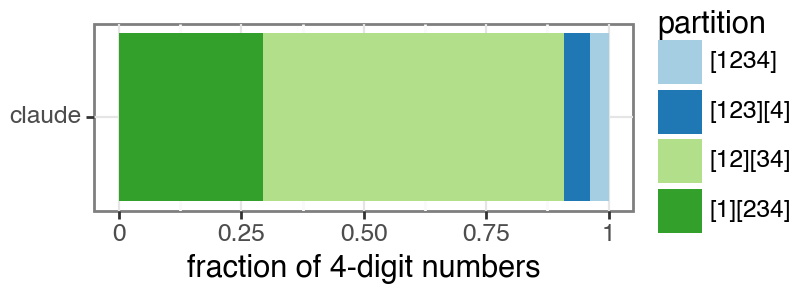


tokenizer        claude
partition              
[1234]       382 (3.8%)
[123][4]     537 (5.4%)
[12][34]   6139 (61.4%)
[1][234]   2942 (29.4%)


In [14]:
#@title Token partitions across tokenizers.
save_fig = False
num_digits = 4 #@param {'type': 'integer'}
leading_whitespace = False #@param {'type': 'boolean'}

# from colorbrewer2.org
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99']
# colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0']

if leading_whitespace:
  ws = 'with'
else:
  ws = 'no'
plot = (gg.ggplot(df[(df['num_digits']==num_digits) & (df['leading_whitespace'] == leading_whitespace)])
             + gg.aes(x='tokenizer', y='fraction', fill='partition') 
             + gg.geom_col()  # additional options
             + gg.coord_flip()
             + gg.theme_bw()
             + gg.theme(figure_size=(4, 1.5), axis_title_y = gg.element_blank())
             + gg.scale_fill_manual(values = colors)
             + gg.ylab('fraction of 4-digit numbers')
             )
print(plot)
if save_fig:
  if leading_whitespace:
    ws_str = 'with_ws'
  else:
    ws_str = 'no_ws'
  plot.save(f'figures/claude_{num_digits}digit_{ws_str}_partitions.pdf')

# print nice table
tmp = df[(df['num_digits']==num_digits) & (df['leading_whitespace'] == leading_whitespace)].copy()
del tmp['num_digits'], tmp['leading_whitespace']
tmp['partition_frac_str'] = tmp['fraction'].apply(lambda x: f"{100*x:.1f}")
tmp['partition_count_str'] = tmp['count'].astype('int').astype('str') + ' (' + tmp['partition_frac_str'] + '%)'
print(tmp.pivot(index=['partition'], columns=['tokenizer'], values='partition_count_str').fillna('0 (0%)'))